<a href="https://colab.research.google.com/github/As-12/Drug-Allergy-Prediction/blob/master/1_Drug_Allergy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Allergy Prediction

### Author
   Thanaphon Chavengsaksongkram

   contact@thanaphon.dev
   
   https://thanaphon.dev

   

### Background

According to the World Health Organization, Drug Allergy is unintended and harmful reactions from drug intake under normal conditions. Drug Allergy presents a serious challenge in healthcare systems as it can increase healthcare costs and deaths.

A laboratory technique called Enzyme-linked immunospot (ELISpot) can test whether the patient's immune cells will respond to particular drugs. This allows a doctor to screen for drug safety for specific patients. Unfortunately, the test does not always guarantee that the patients will not be allergic to the medicine due to the occasional lack of response in ELISpot test and vice versa.

There are several works published regarding drug allergy prediction. [Dey, S., Luo, H., Fokoue, A. et al., 2018](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2544-0) leverages Convolutional Neural Network to predict adverse drug reactions and identify associated molecular substructures. The model performs very well with over 90% accuracy and closes to 85% AUC of the ROC curve via the "Neural Fingerprint" method. On the other hand, [Chen, A, 2018](https://www.ijcmph.com/index.php/ijcmph/article/view/2471/1845) takes the traditional modeling approach and create a model which predict hospitalizations and deaths from drug allergies using supervised learning models including Logistical regression, SVM, and XGradient Boost. The model performs from 65-75% accuracy with the F1 score in the 80s. These studies have access to millions of labeled data points from United States healthcare statistics. 

Real-world data such as biological and medical datasets often suffer small samples with very few labeled datasets. This presents a challenge in creating an effective machine learning model. Technologies such as active learning and semi-supervised learning have been proposed to utilize the unlabeled samples for improving the model performance. [Chai, H., Liang Y., Wang, SS. et al., 2018](https://www.researchgate.net/publication/327287262_A_novel_logistic_regression_model_combining_semi-supervised_learning_and_active_learning_for_disease_classification) proposes a novel approach to this problem by using a logistic regression model with high confidence to propagate labels to the unlabeled dataset. 

### Research Questions

In this task, the goal is to develop a prediction model for drug allergy based on patient and drug information - a binary classification problem. Due to the small dataset and the small dimensionality of the input features, the experiment will leverage simpler traditional machine learning models over complicated deep neural networks. Semi-supervised learning techniques will also be used to accommodate a large number of unlabeled datasets. 

The research questions of this experiment can be summarized as follow:

1 - Can semi-supervised learning techniques such as K-prototype clustering or the novel logistical regression model presented by [Chai, H., Liang Y., Wang, SS. et al., 2018](https://www.researchgate.net/publication/327287262_A_novel_logistic_regression_model_combining_semi-supervised_learning_and_active_learning_for_disease_classification) be used to effectively propagate the training labels?

2 - Can semi-supervised learning techniques improve the final model given a large number of unlabeled samples?

3 - Do machine learning models agree with the assertation of strong predictive property in ELISpot variables to drug allergy?

4 - Given a lack of domain expertise to perform any feature engineering, will model with built-in feature selections such as tree-based models enhance model performance?

5 - What is the best classification model for this task and its performance? Can it perform better than a dummy classifier that simply guesses the answer based on prior probability? 

### Performance measurements

Labeled ground truth will be split for final evaluation while preserving the posterior probability for each class. The model will be assessed based on the macro f-1 score and the area under the curve (AUC) of the receiver operating characteristic (ROC). 



# 0 Environment Setup (Co-lab)

#### 0.1 Install any missing packages

In [1]:
!pip install kmodes

#### 0.2 Importss
It's typical to include package imports at the top of the file for clarity.

In [2]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from statistics import stdev, mean

%matplotlib inline

#Generate random seed for reproducability
seed = 0
rng = np.random.RandomState(seed)


# Ignore warnings for final delivery
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### 0.3 Helper functions

In [0]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1., annot=True)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_ROC(y, y_pred):
    fpr, tpr, threshold = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### 0.4 Mount the drive for data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Exploration

### 1.1 Quick look at the dataset

In [5]:
raw_dataset = pd.read_csv(os.path.join(os.getcwd(), "drive/My Drive/Colab Notebooks/datasets", "DrugAllergyKaggle_v3_050720.csv"), delimiter = ',')
print("There are {} datapoints and {} attributes in the raw dataset.".format(raw_dataset.shape[0], raw_dataset.shape[1]))

There are 799 datapoints and 18 attributes in the raw dataset.


In [6]:
raw_dataset.head(10)

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Score,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result
0,451,0,57,2648,554.0,2.0,1.0,8.0,0,0.0,0,1,0.0,0.0,2,2.0,2,NaN
1,431,0,38,2492,542.0,2.0,1.0,10.0,0,0.0,0,1,0.0,0.0,2,1.0,7,NaN
2,378,0,58,808,439.0,NaN,NaN,4.0,1,0.0,0,1,1.0,0.0,2,6.0,2,NaN
3,101,0,63,2700,431.0,NaN,NaN,16.0,1,0.0,0,0,0.0,0.0,2,2.0,6,NaN
4,352,0,13,2060,338.0,NaN,NaN,NaN,0,0.0,0,0,0.0,0.0,3,1.0,3,NaN
5,383,1,10,2368,273.0,NaN,NaN,NaN,0,0.0,0,0,0.0,1.0,1,6.0,3,NaN
6,399,1,57,1500,232.0,NaN,NaN,NaN,0,0.0,0,0,0.0,0.0,3,6.0,3,NaN
7,550,1,34,1824,225.0,5.0,2.0,2.0,1,0.0,0,0,0.0,0.0,2,7.0,7,NaN
8,212,0,36,2548,218.0,NaN,NaN,11.0,0,0.0,0,1,0.0,0.0,2,5.0,2,NaN
9,69,0,29,2080,207.0,NaN,NaN,12.0,1,0.0,0,1,0.0,1.0,2,1.0,2,NaN


In [7]:
print("Ground Truth Labels")
raw_dataset["Drug_Rechallenge_Result"].value_counts()

Ground Truth Labels


0.0    86
1.0    28
Name: Drug_Rechallenge_Result, dtype: int64

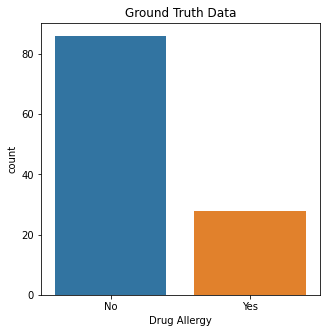

In [8]:
plt.figure(figsize=(5,5))
sns.countplot(x = raw_dataset['Drug_Rechallenge_Result'])
plt.xticks([0,1],['No', 'Yes'])
plt.xlabel('Drug Allergy')
plt.title('Ground Truth Data')
plt.show()

In [9]:
print("Training Label")
raw_dataset["Allergic_Reaction_Group"].value_counts()

Training Label


6.0    196
1.0    174
2.0    115
5.0     84
7.0     68
3.0     57
4.0     42
8.0     35
Name: Allergic_Reaction_Group, dtype: int64

In [10]:
raw_dataset.describe()

,Patient_ID,Gender,Age_Year,ELISpot_Control,ELISpot_Result,Naranjo_Score,Naranjo_Category,Exposure_Time,Steroid_Usage,Underlying_Condition_A,Underlying_Condition_B,Underlying_Condition_C,Underlying_Condition_D,Underlying_Condition_E,Suspicion_Score,Allergic_Reaction_Group,Drug_Group,Drug_Rechallenge_Result
count,799.000000,799.000000,799.000000,799.000000,798.000000,431.000000,509.000000,622.000000,799.000000,781.000000,799.000000,799.000000,785.000000,798.000000,799.000000,771.000000,799.000000,114.000000
mean,375.077597,0.565707,51.012516,1698.603254,11.973684,3.236659,1.198428,428.533762,0.354193,0.070423,0.100125,0.122653,0.187261,0.325815,2.081352,4.014267,3.826033,0.245614
std,144.888087,0.495974,22.344643,879.909460,51.111000,1.796548,0.519234,3922.748736,0.478568,0.256022,0.300355,0.328244,0.390370,0.468972,0.380792,2.313945,2.513826,0.432351
min,2.000000,0.000000,0.000000,60.000000,0.000000,-3.000000,0.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,318.000000,0.000000,36.000000,1120.000000,0.000000,2.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,0.000000
50%,403.000000,1.000000,53.000000,1592.000000,0.000000,3.000000,1.000000,10.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,3.000000,0.000000
75%,486.000000,1.000000,70.000000,2166.000000,0.000000,4.000000,1.000000,21.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,6.000000,7.000000,0.000000
max,570.000000,1.000000,97.000000,5290.000000,554.000000,9.000000,3.000000,43281.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,8.000000,8.000000,1.000000


In [11]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               799 non-null    int64  
 1   Gender                   799 non-null    int64  
 2   Age_Year                 799 non-null    int64  
 3   ELISpot_Control          799 non-null    int64  
 4   ELISpot_Result           798 non-null    float64
 5   Naranjo_Score            431 non-null    float64
 6   Naranjo_Category         509 non-null    float64
 7   Exposure_Time            622 non-null    float64
 8   Steroid_Usage            799 non-null    int64  
 9   Underlying_Condition_A   781 non-null    float64
 10  Underlying_Condition_B   799 non-null    int64  
 11  Underlying_Condition_C   799 non-null    int64  
 12  Underlying_Condition_D   785 non-null    float64
 13  Underlying_Condition_E   798 non-null    float64
 14  Suspicion_Score          7

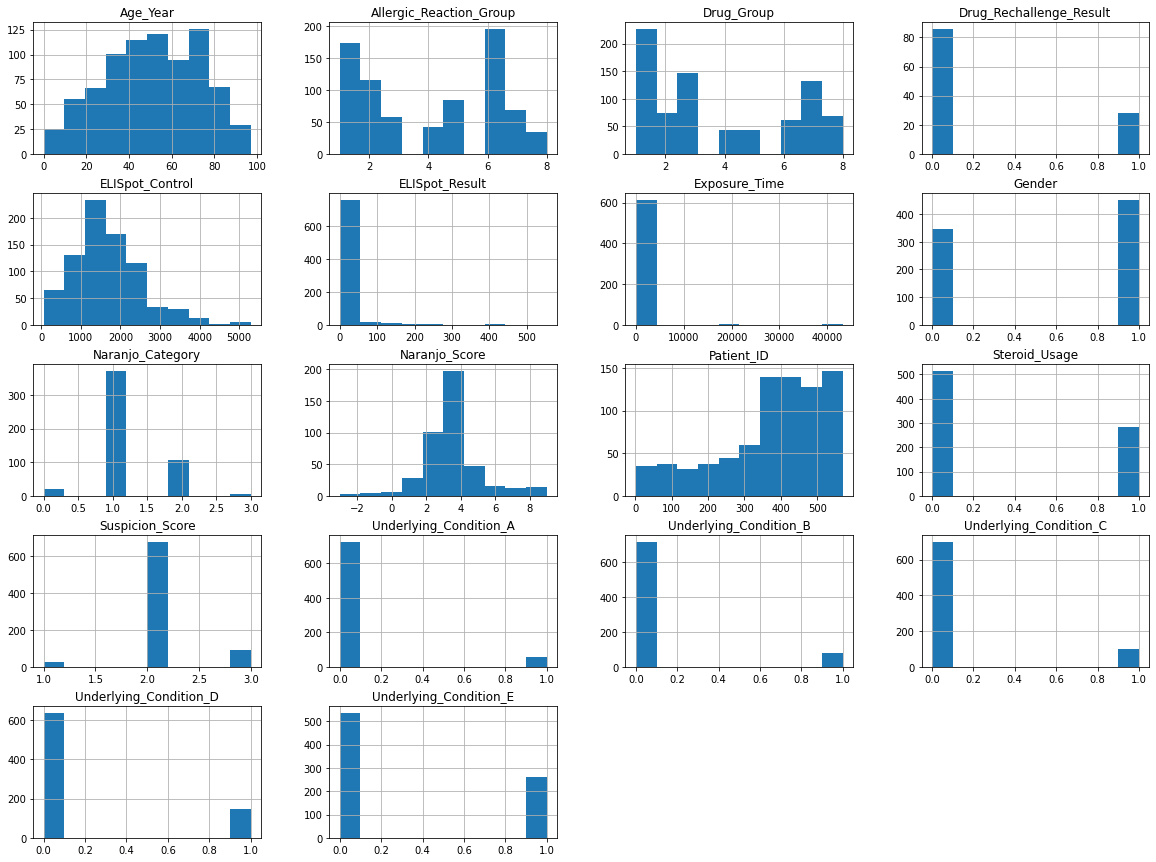

In [12]:
raw_dataset.hist(figsize=(20,15))
plt.title("Count plot of all features")
plt.show()

### 1.2 Explaination of each variables

#### ELISpot_Control 
The ELISpot test result for the POSITIVE CONTROL (i.e., we expect to see strong response)

#### ELISpot_Result 
The ELISpot test result for SUSPECTED DRUG (i.e., this is the result that indicate whether the patient would be allergic to that drug)

#### NARANJO_Category 
An ordinal data.

#### Exposure_Time 
The amount of times since the patient has taken the drug until the ELISpot test date.

#### Suspicion_Score
The suspicion level of the drug (1 = suspected drug, 2 = similar to suspected drug, 3 = negative control). This is ORDINAL.

#### Allergic_Reaction_Group 
The severity of patient's allergic reaction. This is ORDINAL.

#### Drug_Group 
A categorical data.

#### Drug_Rechallenge_Result
The ground truth of this dataset that we want to predict.

# 2. Data Analysis

#### 2.1 Categorical, Ordinal, and Continous Variables

It is important to separate these variables as some machine learning algorithms require categorical data to be encoded and numerical data to be standardized. Binary categorical variables are inherently encoded.


In [0]:
continous_variable_columns = ['Age_Year', 'ELISpot_Control', 'ELISpot_Result', 'Naranjo_Score', 'Exposure_Time']
ordinal_variable_columns =  ['Naranjo_Category', 'Suspicion_Score', 'Allergic_Reaction_Group', 'Suspicion_Score']
binary_variable_columns = ['Gender', 'Steroid_Usage', 'Underlying_Condition_A', 'Underlying_Condition_B', 'Underlying_Condition_C', 'Underlying_Condition_D', 'Underlying_Condition_E']
categorical_variable_columns = ['Drug_Group']

#### 2.2 Target Label

Drug_Rechallenge_Result is the ground truth of this dataset. This is the dependent variable the model will try to predict.


In [0]:
target_column = 'Drug_Rechallenge_Result'


#### 2.3 Patient_ID

Patient_ID is a database primary key. It is to be discarded as it serves no statistical significance. 



In [0]:
raw_dataset = raw_dataset.drop(['Patient_ID'], 1)

#### 2.4 Association Analysis and Dimensionality Reduction

Although this is a binary classification task, it may still be useful to visualize the strength of the association between the continuous variables and to gain some insight about a particular feature. Highly correlated independent variables could be compressed further using dimensionality reduction techniques such as PCAs to improve training performance.

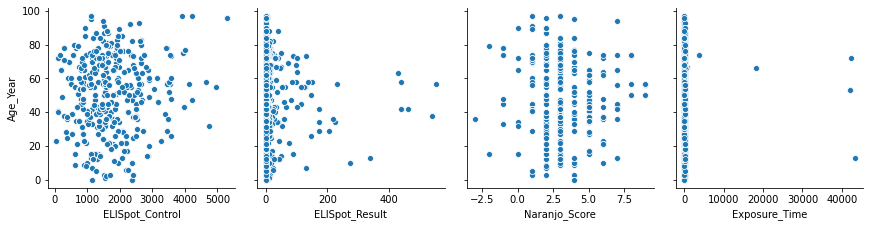

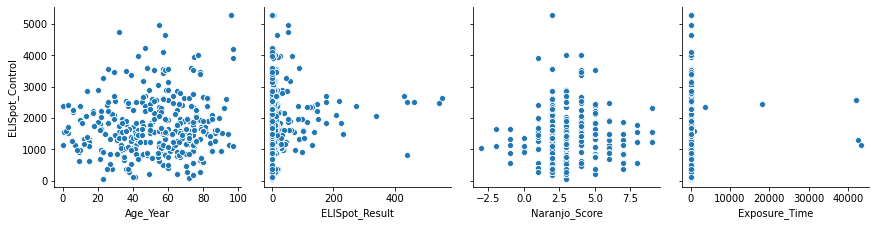

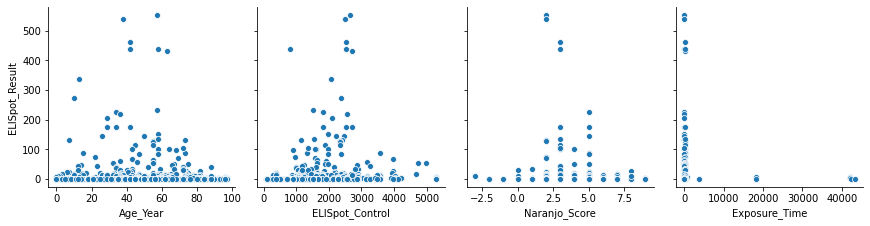

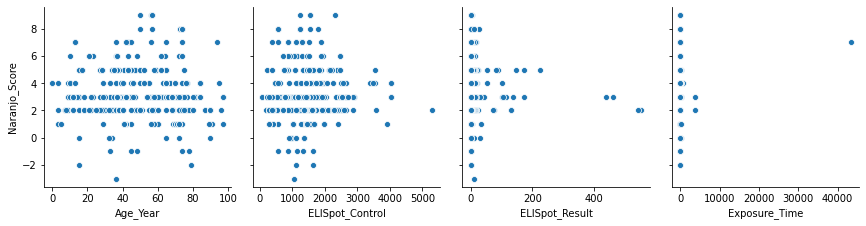

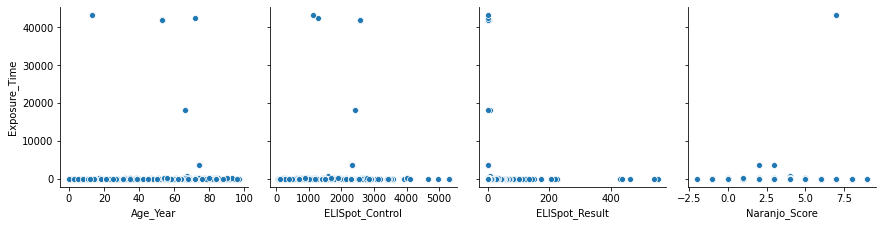

In [16]:
#Split data into batches for easier viewing. There are 15 columns

for row in continous_variable_columns:
    columns = []
    for column in continous_variable_columns:
        if row != column:
             columns.append(column)    
    sns.pairplot(data=raw_dataset,y_vars=[row],x_vars=columns, height=3)    
plt.show()

##### 2.4.1  Scatterplots Analysis

It does not appear to have any strong linear relationships among the independent continuous variables. Therefore, PCA will not be an attempt in this experiment.

#### 2.5 ELISpot_Control and Outliers

ELISpot_Control seems to follow a normal distribution but there appear to be some bad outliers based on  IQR, std, min, max, and mean. 
This outlier will be dealt with using the empirical rule (3 sigma rule).

Outliers can introduce bias into the model during the training phase, but the effect of outliers may still be useful during the inference phase. Therefore, eliminating outliers during model development may be preferred over minimizing the outlier effect through log transformation. 


In [17]:
index = np.abs(raw_dataset['ELISpot_Control'] - raw_dataset['ELISpot_Control'].mean()) / raw_dataset['ELISpot_Control'].std() <= 3
raw_dataset = raw_dataset[index]
raw_dataset.shape

(791, 17)

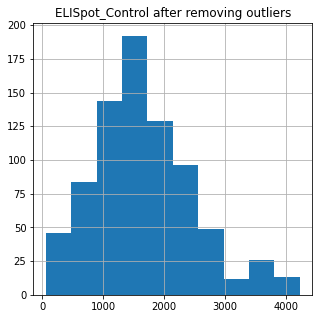

In [18]:
raw_dataset["ELISpot_Control"].hist(figsize=(5,5))
plt.title("ELISpot_Control after removing outliers")
plt.show()

# 3. Data Preprocessing
#### 3.1 Labeled and Unlabeled Data

Split labeled and unlabeled data.

In [19]:
# We can use NaN != NaN to split labeled data
unlabeled_data = raw_dataset.query("Drug_Rechallenge_Result != Drug_Rechallenge_Result")
labeled_data = raw_dataset.query("Drug_Rechallenge_Result == Drug_Rechallenge_Result")
print("There are {} labeled data points and {} unlabeled data points.".format(labeled_data.shape[0], unlabeled_data.shape[0]))

There are 113 labeled data points and 678 unlabeled data points.


#### Sanity Checks

Labeled data should have 1s and 0s. Unlabeled data should have all NaN.


In [20]:
labeled_data["Drug_Rechallenge_Result"].head(5)

16    0.0
19    1.0
27    1.0
31    0.0
37    1.0
Name: Drug_Rechallenge_Result, dtype: float64

In [21]:
unlabeled_data["Drug_Rechallenge_Result"].head(5)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Drug_Rechallenge_Result, dtype: float64

In [0]:
labeled_data_X = labeled_data.drop([target_column], 1)
labeled_data_Y = labeled_data[target_column]

unlabeled_data_X = unlabeled_data.drop([target_column], 1)
unlabeled_data_Y = unlabeled_data[target_column]

#### 3.2 Training and Validation Data

Because the dataset is partially labeled, half of the labeled data will be split into validation and training set. 

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=2, random_state=None, test_size=0.5)
[index, _] = splitter.split(labeled_data_X, labeled_data_Y)

train_X = labeled_data_X.iloc[index[0]]
train_Y = labeled_data_Y.iloc[index[0]]
test_X = labeled_data_X.iloc[index[1]]
test_Y = labeled_data_Y.iloc[index[1]]

In [24]:
print("There are {} training data points and {} validation data points".format(train_X.shape[0], test_X.shape[0]))

There are 56 training data points and 57 validation data points


#####  3.2.1 Sanity Check

Check if the split works correctly and preserves the class ratio.

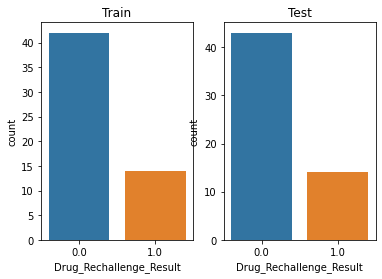

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(x = train_Y, ax=ax1)
ax1.set_title("Train")
sns.countplot(x = test_Y, ax=ax2)
ax2.set_title("Test")
plt.show()

#### 3.3 Imputing Missing Value 

There are quite a bit of missing Data points in many of the input variables. This requires imputation before it can be processed by Machine Learning algorithms. There are many methods to impute data and it often depends on the context. In some circumstances, replacing missing data might be the wrong thing to do, and zero out the values might have been better. Unfortunately, due to the lack of domain expertise, this experiment will impute based on median value for continuous data and based on mode for everything else.

#### 3.4 Standardize Continous Variable 

Machine Learning algorithms that use distance metrics such as Mean Square Error are generally sensitive to outliers and differences in Scale. Standardizing these features to zero mean and unit variance can lead to better performance. SKlearn's RobustScaler will be used in this task to standardize the data while minimizing the effect of outliers.

#### 3.5 Categorical Data Encoding

Many machine learning models do not accept categorical data points. They will have to be encoded using One-Hot Encoding. The exception to this is the binary categorical data, as they are inherently encoded.

#### 3.5 Preprocessing Pipeline

Wrapping up the preprocessing steps into a pipeline. One with one-hot encoding and the other without to accommodate certain algorithms.



In [0]:
# Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

# Preprocessing Pipelines
preprocessor_with_one_hot = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, continous_variable_columns),
        ('ord', ordinal_transformer, ordinal_variable_columns),
        ('bin', binary_transformer, binary_variable_columns),
        ('cat', categorical_onehot_transformer, categorical_variable_columns)])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, continous_variable_columns),
        ('ord', ordinal_transformer, ordinal_variable_columns),
        ('bin', binary_transformer, binary_variable_columns),
        ('cat', categorical_transformer, categorical_variable_columns)])


# Numerical Column Index
category_column_index = [train_X.columns.get_loc(c) for c in categorical_variable_columns if c in train_X]


# 4. Semi-Supervised Learning

Due to a large number of the unlabeled dataset, K-prototype and Logistical regression will be trained over the labeled samples then attempt to propagate the labels over the unlabeled samples. 

#### 4.1 Label Propagation using K-prototype

K-prototype is a variant of Kmean and Kmode unsupervised learning model to deal with a combination of ordinal, categorical, and numerical datasets. 

In [0]:
cluster_clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('cluster', KPrototypes(n_clusters=2, init='Huang', random_state=0))])
cluster_clf.fit(train_X, train_Y, cluster__categorical=category_column_index)
y_predict = cluster_clf.predict(train_X, categorical=category_column_index)

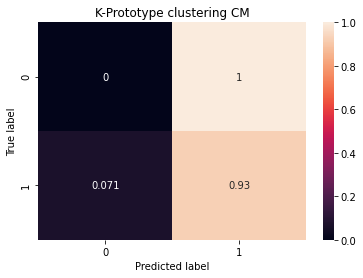

In [28]:
cm = confusion_matrix(train_Y, y_predict)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, title="K-Prototype clustering CM")    
plt.show()

##### 4.1.1 K-prototype result

Unfortunately, based on the confusion matrix alone. K-prototype gives no meaningful clusters as it labels almost everything into one particular class. Hence, it will not be used for label propagation.

#### 4.2 Label Propagation using Logistical Regression

Based on the method proposed by  [Chai, H., Liang Y., Wang, SS. et al., 2018](https://www.researchgate.net/publication/327287262_A_novel_logistic_regression_model_combining_semi-supervised_learning_and_active_learning_for_disease_classification), a logistical regressor will be trained and samples with high confidence will see label propagation. 


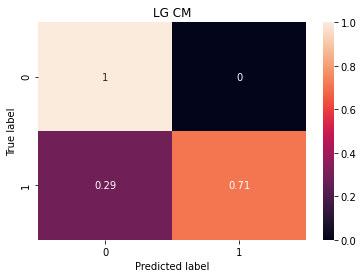

In [29]:
lg_clf = Pipeline(steps=[('preprocessor', preprocessor_with_one_hot),
                  ('classification', LogisticRegression(random_state=0, max_iter=20000))]) 
lg_clf.fit(train_X, train_Y)
y_predict = lg_clf.predict(train_X)
cm = confusion_matrix(train_Y, y_predict)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, title="LG CM")    
plt.show()

##### 4.2.1 Logistical regression result

The logistical regression performs relatively well based on the Confusion Matrix. 

##### 4.2.2 Identify high confidence samples

Leverage Logistical regression to identify samples with a very high classification confidence. (Over 90% for each class).

In [0]:
prob_Y = lg_clf.predict_proba(unlabeled_data_X)

threshold = 0.9

i = 0
for a,b in prob_Y:
    if a >= threshold:
        unlabeled_data_Y.iloc[i] = 0
    elif b >= threshold:
        unlabeled_data_Y.iloc[i] = 1
    else:
        unlabeled_data_Y.iloc[i] = -1
    i += 1

index = unlabeled_data_Y >= 0        

#### 4.3 Label Propagation

Propagate identified samples to the new augmented dataset.

In [31]:
augmented_train_X = train_X.append(unlabeled_data_X[index])
augmented_train_Y = pd.Series([*train_Y, *unlabeled_data_Y[index]])
print("New augmented training set has {} data points".format( augmented_train_X.shape[0]))

New augmented training set has 500 data points


# 5. Model Selections

In this section, several machine learning models will be trained and evaluated against the augmented training set. Ideally, the one with a significantly higher averaged macro f1 score across all cross-validations will be selected for final evaluation.

#### 5.0.1  Evaluate Function

The following function will evaluate model performance by calculating the average macro F-1 score across 5 folds. Then display a confusion matrix from one of the folds for a sanity check.

In [0]:
def evaluate_clf(clf, clf_name):
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
    count = 0
    f1_sum = 0
    for train_index, test_index in skf.split(augmented_train_X, augmented_train_Y):
        X_tr, X_val = augmented_train_X.iloc[train_index], augmented_train_X.iloc[test_index]
        Y_tr, Y_val = augmented_train_Y.iloc[train_index], augmented_train_Y.iloc[test_index]    
        clf.fit(X_tr, Y_tr)    
        y_predict = clf.predict(X_val)
        f1_sum += f1_score(Y_val, y_predict, average='macro')
        count += 1
    # Display CM from one of the K fold
    cm = confusion_matrix(Y_val, y_predict)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm, title="CM for {}".format(clf_name))    
    plt.show()
    
    # Show average F-1 scores across all folds
    print("Average Macro F-1 Score: {}".format(f1_sum/count))    

#### 5.1 Gaussion Naive Bayes

Are input features conditionally independent? Naive Bayes can give more insight into this relationship.


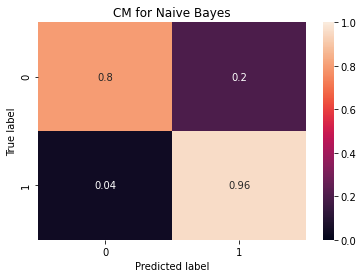

Average Macro F-1 Score: 0.8187340641384759


In [33]:
naive_bayes_clf = Pipeline(steps=[('preprocessor', preprocessor_with_one_hot),
                  ('classification',GaussianNB())]) 
evaluate_clf(naive_bayes_clf, "Naive Bayes")

##### 5.1.1 Discussion

Result suggests good training performance. Input features are likely to be independent.

#### 5.2 Random Forest

Random Forest creates boundary lines based on discriminative features and automatically perform feature selections. This can give some insights into the most discriminating feature of the dataset.

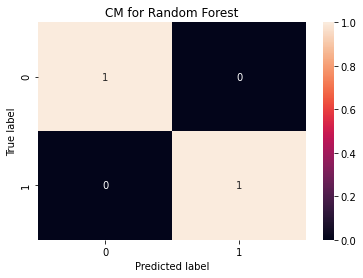

Average Macro F-1 Score: 0.9786568895405224


In [34]:
random_forest_clf = Pipeline(steps=[('preprocessor', preprocessor_with_one_hot),
                  ('classification',RandomForestClassifier())]) 
evaluate_clf(random_forest_clf, "Random Forest")

##### 5.2.1 Random Forest - Relative Feature Importance

Rank each feature based on most discriminative features such as Information Gain, etc.

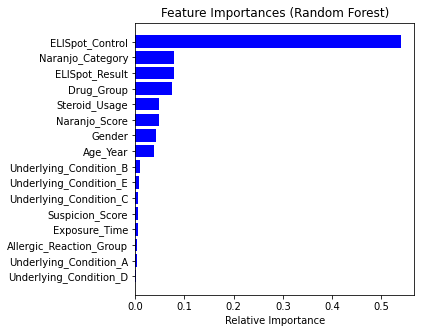

In [35]:
# Reconstruct the input column name after one hot encoding

Drug_Group = [ "Drug_Group" for c in range(1, 9)]

one_hot_encoded_features = ['Gender', 'Age_Year', 'ELISpot_Control', 'ELISpot_Result',
       'Naranjo_Score', 'Naranjo_Category', 'Exposure_Time', 'Steroid_Usage',
       'Underlying_Condition_A', 'Underlying_Condition_B',
       'Underlying_Condition_C', 'Underlying_Condition_D',
       'Underlying_Condition_E', 'Suspicion_Score', 'Allergic_Reaction_Group',
       *Drug_Group]

one_hot_encoded_importance = random_forest_clf.steps[1][1].feature_importances_


# Aggregate the importance value for each feature 
features_importances = {}  

for imp, fea in zip(one_hot_encoded_importance, one_hot_encoded_features):
    if fea not in features_importances:
        features_importances[fea] = 0
    features_importances[fea] += imp

# Display the feature importance
features = list(features_importances.keys())
importances = np.array(list(features_importances.values()))
indices = np.argsort(importances)

plt.figure(figsize=(5,5))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 5.3 XGradientBoost
XGradient Boost is a popular tree-based ensemble model that often outperforms Random Forest in Kaggle competitions. 

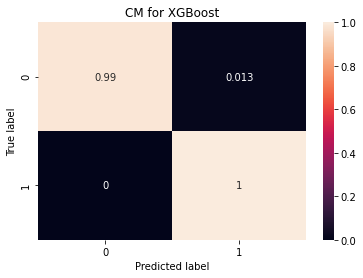

Average Macro F-1 Score: 0.9620247590235242


In [36]:
xgb_clf = Pipeline(steps=[('preprocessor', preprocessor_with_one_hot),
                  ('classification', xgb.XGBClassifier())]) 
evaluate_clf(xgb_clf, "XGBoost")

##### 5.3.1 XGBoost - Relative Feature Importance

Rank each feature based on the most discriminative features.

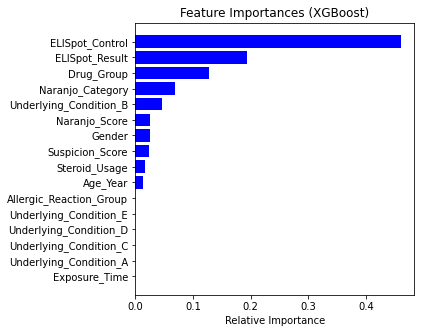

In [37]:
# Aggregate the importance value for each feature 
one_hot_encoded_importance = xgb_clf.steps[1][1].feature_importances_
features_importances = {}  

for imp, fea in zip(one_hot_encoded_importance, one_hot_encoded_features):
    if fea not in features_importances:
        features_importances[fea] = 0
    features_importances[fea] += imp

# Display the feature importance
features = list(features_importances.keys())
importances = np.array(list(features_importances.values()))
indices = np.argsort(importances)

plt.figure(figsize=(5,5))
plt.title('Feature Importances (XGBoost)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### 5.3.1 Discussion

The tree models performed quite well. The most discriminative features are ELISpot variables, which agree with the initial assertion.

#### 5.4 Support Vector Machine (Linear Kernel) 

Support Vector Machine generally performs well on a medium to small size dataset. 

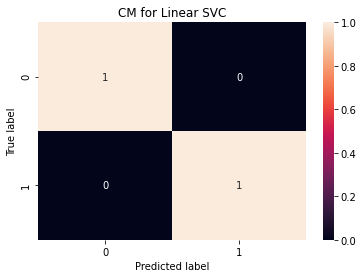

Average Macro F-1 Score: 0.9785077667335049


In [38]:
linear_svc_clf = Pipeline(steps=[('preprocessor', preprocessor_with_one_hot),
                  ('classification', LinearSVC(penalty='l2', loss='squared_hinge',  max_iter=100000, dual = False) )]) 
evaluate_clf(linear_svc_clf, "Linear SVC")

### 5.5 Model Selection

The clear winner cannot be determined due to the marginal differences in the average F-1 score for each model. This score will likely have a high variance as the sample size is quite small. 

Despite this, the XGBoost model will be selected for final evaluation due to a slightly better average F-1 macro score in some executions. Tree-based algorithms also have much better explainability in higher-dimensional space.

# 6. Model Optimization

From the previous section, XGBoost performed the best on the training data. This step will optimize XGBoost for optimal hyperparameter using Grid search.

In [39]:

from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform


optimization_dict = {'max_depth': [2,4,6,8,10,12,14,16,18,20],
                     'n_estimators': [50,100,200,400]}

clf = GridSearchCV(xgb.XGBClassifier(), optimization_dict, scoring="f1_macro")
clf.fit(preprocessor_with_one_hot.fit_transform(augmented_train_X),augmented_train_Y)

print("Best XGBoost parameters")
print(clf.best_score_)
print(clf.best_params_)

Best XGBoost parameters
0.967701754385965
{'max_depth': 2, 'n_estimators': 100}


# 7. Model Evaluation

This section evaluates XGBoost against the Test dataset and baseline classifiers.



### 7.1 XGBoost Evaluation - with artificially labelled dataset


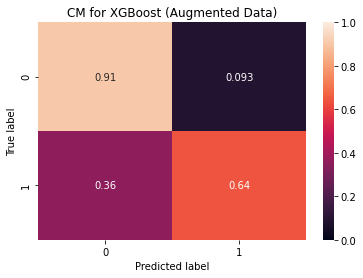

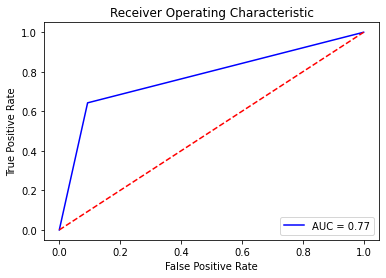

Precision 0.7893356643356644 std: 0.0
Recall    0.7749169435215947 std: 0.0
F1        0.7816091954022988 std: 0.0


In [43]:
precision = []
recall = []
f1 = []
for i in range(10):
    xgb_clf = Pipeline(steps=[('preprocessor', preprocessor_with_one_hot),
                  ('classification', xgb.XGBClassifier(max_depth=2, n_estimators=100))]) 
    xgb_clf.fit(augmented_train_X, augmented_train_Y)
    y_predict = xgb_clf.predict(test_X)
    scores = precision_recall_fscore_support(test_Y, y_predict, average='macro')
    precision.append(scores[0])
    recall.append(scores[1])
    f1.append(scores[2])

# Display CM from one of tests
cm = confusion_matrix(test_Y, y_predict)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, title="CM for XGBoost (Augmented Data)")    
plt.show()

# Plot ROC
plot_ROC(test_Y, y_predict)

# Summarize Scores
print("Precision {} std: {}".format(mean(precision), stdev(precision)))
print("Recall    {} std: {}".format(mean(recall), stdev(recall)))
print("F1        {} std: {}".format(mean(f1), stdev(f1)))

### 7.2 XGBoost Evaluation - with only ground truth label


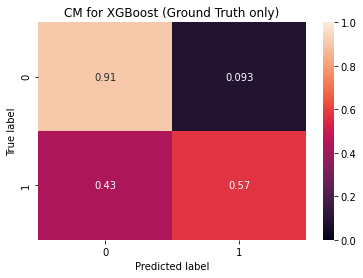

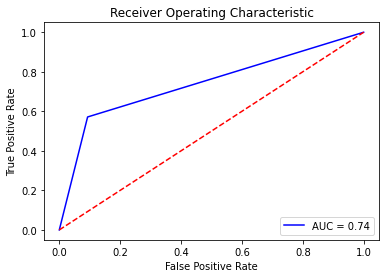

Precision 0.7666666666666666 std: 0.0
Recall    0.739202657807309 std: 0.0
F1        0.7508741258741258 std: 0.0


In [44]:
precision = []
recall = []
f1 = []
for i in range(10):
    xgb_clf2 = Pipeline(steps=[('preprocessor', preprocessor_with_one_hot),
                  ('classification', xgb.XGBClassifier(max_depth=2, n_estimators=100))]) 
    xgb_clf2.fit(train_X, train_Y)
    y_predict = xgb_clf.predict(test_X)
    scores = precision_recall_fscore_support(test_Y, y_predict, average='macro')
    precision.append(scores[0])
    recall.append(scores[1])
    f1.append(scores[2])

# Display CM from one of tests
cm = confusion_matrix(test_Y, y_predict)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, title="CM for XGBoost (Ground Truth only)")    
plt.show()

# Plot ROC
plot_ROC(test_Y, y_predict)

# Summarize Scores
print("Precision {} std: {}".format(mean(precision), stdev(precision)))
print("Recall    {} std: {}".format(mean(recall), stdev(recall)))
print("F1        {} std: {}".format(mean(f1), stdev(f1)))

### 7.3 Dummy Classifier

Evaluate a classifier where the only prediction it makes is zero (No Allergy).

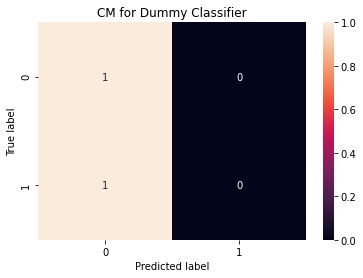

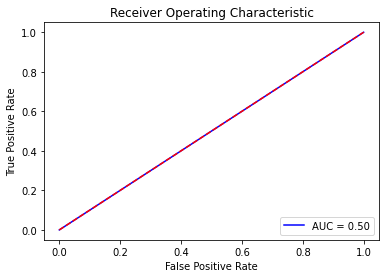

Precision 0.37719298245614036 std: 0.0
Recall    0.5 std: 0.0
F1        0.43 std: 0.0


In [42]:
precision = []
recall = []
f1 = []
for i in range(10):
    dummy_clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classification', DummyClassifier(strategy='constant', constant=0))]) 
    dummy_clf.fit(train_X, train_Y)
    y_predict = dummy_clf.predict(test_X)
    scores = precision_recall_fscore_support(test_Y, y_predict, average='macro')
    precision.append(scores[0])
    recall.append(scores[1])
    f1.append(scores[2])

# Display CM from one of tests
cm = confusion_matrix(test_Y, y_predict)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, title="CM for Dummy Classifier".format("s"))    
plt.show()

# Plot ROC
plot_ROC(test_Y, y_predict)

# Summarize Scores
print("Precision {} std: {}".format(mean(precision), stdev(precision)))
print("Recall    {} std: {}".format(mean(recall), stdev(recall)))
print("F1        {} std: {}".format(mean(f1), stdev(f1)))

# 8. Conclusion

In this experiment, I have explored the patient data and drug information in an attempt to create a predictive model that would identify vulnerable patients. Due to the lack of labeled data, a semi-supervised learning technique is deployed to increase training data size the supervised several machine learning models.

Initially, a Logistical Regression model is trained from the labeled dataset, then propagate the label over to unlabeled data. Several models are evaluated afterward. Tree-based models score better average macro F-1 score in several executions with some noise and they have a better explainability compared to other models. Hence, XGBoost is selected to perform the final evaluation against the test dataset with an average F1 macro score of roughly 0.78 and AUC of  0.77. Compared to the XGBoost model using the human-labeled dataset, the augmented model sees small improvement over the model without label propagation. Dummy baseline classifier is also trained and evaluated with a 0.43 macro F1 score and 0.5 AUC, significantly underperforming against XGBoost. 

During the experimentation, Random Forest and XGBoost find the most discriminative feature of this dataset to be the EL5Spot variable. This agrees with the expert assertation that the EL5Spot is the best indicator of drug allergy.

In conclusion, this experiment paints a promising result in using a semi-supervised learning model for predicting drug allergy in patients using only a small sample of labeled data. Nevertheless, future studies should be conducted with more human-labeled data to reaffirm this finding. Small evaluation and training dataset can introduce sampling errors with high variance. 

